In [28]:
import csv
import pandas as pd
import unicodecsv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, Dropout, Activation, Embedding, Bidirectional

In [2]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/pranav/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
vocab_size = 5000 # make the top list of words (common words)
embedding_dim = 50
max_length = 20
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>' # OOV = Out of Vocabulary

In [70]:
train_articles = []
train_labels = []
validation_articles = []
validation_labels = []
test_labels = []
test_articles = []

train_df = pd.read_csv('data/Constraint_Train.csv')
train = train_df.values

val_df = pd.read_csv('data/Constraint_Val.csv')
val = val_df.values

# test_df = pd.read_csv('data/Constraint_Test.csv')
# test = test_df.values

for row in train:
    train_articles.append(row[1])
    train_labels.append(row[2])
    
for row in val:
    validation_articles.append(row[1])
    validation_labels.append(row[2])
    
# for row in test:
#     test_articles.append(row[1])
#     print(row[1])
#     print(row[2])
#     test_labels.append(row[2])
    
labels = ['real', 'fake']

In [58]:
print(train_articles[0])
print(train_labels[0])

The CDC currently reports 99031 deaths. In general the discrepancies in death counts between different sources are small and explicable. The death toll stands at roughly 100000 people today.
real


In [59]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_articles)
word_index = tokenizer.word_index

In [60]:
print(word_index)

{'<OOV>': 1, 'the': 2, 'of': 3, 't': 4, 'co': 5, 'https': 6, 'to': 7, 'in': 8, 'a': 9, 'and': 10, 'covid': 11, 'is': 12, '19': 13, 'for': 14, 'cases': 15, 'coronavirus': 16, 'are': 17, 'covid19': 18, 'that': 19, 'on': 20, 'from': 21, 'new': 22, 'have': 23, 'with': 24, 'has': 25, 'as': 26, 'we': 27, 'at': 28, 'this': 29, 'people': 30, 'more': 31, 'tests': 32, 'be': 33, 'by': 34, 'india': 35, 'deaths': 36, 'not': 37, '1': 38, 'our': 39, 'it': 40, 'been': 41, 'there': 42, 'states': 43, '2': 44, 'number': 45, 'total': 46, 'who': 47, 'confirmed': 48, 'will': 49, 'you': 50, 'amp': 51, 'reported': 52, 'can': 53, 'testing': 54, 'was': 55, 'all': 56, 'than': 57, 'health': 58, 'now': 59, '3': 60, 'or': 61, 'state': 62, 'today': 63, 'an': 64, 'no': 65, 'but': 66, 'one': 67, 'if': 68, 'they': 69, 'your': 70, 'day': 71, 'up': 72, 'indiafightscorona': 73, 'report': 74, 'pandemic': 75, 'which': 76, 'about': 77, 'virus': 78, 'hospital': 79, 'case': 80, 'patients': 81, 'vaccine': 82, 'says': 83, '5': 8

In [61]:
train_sequences = tokenizer.texts_to_sequences(train_articles)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
validation_sequences = tokenizer.texts_to_sequences(validation_articles)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [62]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))

In [63]:
print(set(labels))

{'fake', 'real'}


In [64]:
label_tokenizer.word_index

{'real': 1, 'fake': 2}

In [65]:
print(training_label_seq.shape)
print('-------------')
print(validation_label_seq.shape)

(6420, 1)
-------------
(2140, 1)


In [66]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
#model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(embedding_dim)))
model.add(Dense(7, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 50)          250000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100)               40400     
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 707       
Total params: 291,107
Trainable params: 291,107
Non-trainable params: 0
_________________________________________________________________


In [67]:
opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy'],
)

In [68]:
num_epochs = 50
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=2)

Epoch 1/50
201/201 - 6s - loss: 0.5117 - accuracy: 0.8014 - val_loss: 0.2156 - val_accuracy: 0.9089
Epoch 2/50
201/201 - 2s - loss: 0.1548 - accuracy: 0.9364 - val_loss: 0.2777 - val_accuracy: 0.8944
Epoch 3/50
201/201 - 2s - loss: 0.0708 - accuracy: 0.9773 - val_loss: 0.2104 - val_accuracy: 0.9243
Epoch 4/50
201/201 - 2s - loss: 0.0338 - accuracy: 0.9900 - val_loss: 0.2849 - val_accuracy: 0.9164
Epoch 5/50
201/201 - 2s - loss: 0.0181 - accuracy: 0.9949 - val_loss: 0.2910 - val_accuracy: 0.9192
Epoch 6/50
201/201 - 2s - loss: 0.0094 - accuracy: 0.9978 - val_loss: 0.3323 - val_accuracy: 0.9126
Epoch 7/50
201/201 - 2s - loss: 0.0040 - accuracy: 0.9995 - val_loss: 0.4064 - val_accuracy: 0.9117
Epoch 8/50
201/201 - 2s - loss: 0.0013 - accuracy: 0.9998 - val_loss: 0.4516 - val_accuracy: 0.9065
Epoch 9/50
201/201 - 2s - loss: 8.5729e-04 - accuracy: 1.0000 - val_loss: 0.4640 - val_accuracy: 0.9042
Epoch 10/50
201/201 - 2s - loss: 3.9130e-04 - accuracy: 1.0000 - val_loss: 0.4867 - val_accuracy

In [71]:
#print((validation_labels[0]))
#print((validation_articles[0]))
test_articles = validation_articles
test_labels = validation_articles

fake
Chinese converting to Islam after realising that no muslim was affected by #Coronavirus #COVD19 in the country


In [78]:
tokenizer.fit_on_texts(test_articles)
test_sequences = tokenizer.texts_to_sequences(test_articles)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [84]:
i = 0
correct = 0.0;
total = 0.0;
ans = []
prediction = []
test_articles = validation_articles
test_labels = validation_labels
for i in range(len(test_articles)):    
    txt = [];
    txt.append(test_articles[i])
    print(txt)
    seq = tokenizer.texts_to_sequences(txt)
    padded = pad_sequences(seq, maxlen=30)
    pred = model.predict(padded)
    #labels = ['halfTrue', 'false', 'mostlyTrue', 'barelyTrue', 'true', 'pantsFire']
    labels = ['real', 'fake']
    prediction.append(labels[np.argmax(pred)-1])
    ans.append(test_labels[i])
    if(labels[np.argmax(pred)-1] == test_labels[i]):
        #print("true" + "   || Truth:  " + test_labels[i] + " predicted: " + labels[np.argmax(pred)-1])
        correct += 1;
    else:
        #print("false" + "   || Truth:  " + test_labels[i] + " predicted: " + labels[np.argmax(pred)-1])
    total += 1;

['Chinese converting to Islam after realising that no muslim was affected by #Coronavirus #COVD19 in the country']
true   || Truth:  fake predicted: fake
['11 out of 13 people (from the Diamond Princess Cruise ship) who had intially tested negative in tests in Japan were later confirmed to be positive in the United States.']
false   || Truth:  fake predicted: real
['COVID-19 Is Caused By A Bacterium, Not Virus And Can Be Treated With Aspirin']
true   || Truth:  fake predicted: fake
["Mike Pence in RNC speech praises Donald Trump’s COVID-19 “seamless” partnership with governors and leaves out the president's state feuds: https://t.co/qJ6hSewtgB #RNC2020 https://t.co/OFoeRZDfyY"]
false   || Truth:  fake predicted: real
["6/10 Sky's @EdConwaySky explains the latest #COVID19 data and government announcement. Get more on the #coronavirus data here👇 https://t.co/jvGZlSbFjH https://t.co/PygSKXesBg"]
false   || Truth:  real predicted: fake
['No one can leave managed isolation for any reason wi

true   || Truth:  fake predicted: fake
['Patients with #COVID + obesity are at nearly 50% higher risk of death study finds. https://t.co/a2IdFXEtUK https://t.co/TaNov2xuss']
false   || Truth:  real predicted: fake
['EMA endorses the use of dexamethasone for COVID-19. https://t.co/RKPH74Hz3W']
false   || Truth:  real predicted: fake
['CDC: First in line should be healthcare and essential workers and those at high risk. https://t.co/ZBfEW70P1E #covid19']
false   || Truth:  real predicted: fake
['Public Health Professionals: Need #COVID19 resources for sharing? Check out CDC’s One-Stop Shop for COVID-19 Resources that range from youth sports to travel: https://t.co/EpQe5KaDvq. https://t.co/CLv3Qj3ZeJ']
true   || Truth:  real predicted: real
['Is Coranavirus a biological Weapon developed by the Chinese called Wuhan -400? This book was published in 1981. Do read the excerpt.']
true   || Truth:  fake predicted: fake
["It’s been over six months since the first confirmed case of COVID-19 in th

true   || Truth:  real predicted: real
["A sample of COVID-19 patients reported typical symptoms such as fever cough shortness of breath but also symptoms like fatigue diarrhea muscle aches headache and chills. Read more about #COVID19 symptoms in today's @CDCMMWR: https://t.co/CjFU87WGPd. https://t.co/97vWRc9N8F"]
true   || Truth:  real predicted: real
['#Great news! Carona virus vaccine ready. Able to cure patient within 3 hours after injection. Hats off to US Scientists. Trump announced that Roche Medical Company will launch the vaccine next Sunday, and millions of doses are ready from it!']
false   || Truth:  fake predicted: real
["Sir Keir Starmer is out of isolation after his child tested negative for #coronavirus. However he still won't be appearing at #PMQs today with Labour deputy leader Angela Rayner to face Boris Johnson in the House of Commons instead. Live updates: https://t.co/irokoSsks2 https://t.co/p4tb0Njnbm"]
true   || Truth:  real predicted: real
['The coronavirus is

true   || Truth:  fake predicted: fake
["Coronavirus is hitting Pakistan so badly . You can see the conditions of hospital in Pakistan and there's no space in hospitals for corona patient .So please take it serious this is a worldwide dangerous virus"]
true   || Truth:  fake predicted: fake
['184 new cases of #COVID19; 51-Lagos 23-Jigawa 16-Bauchi 16-Katsina 14-Kano 10-FCT 10-Rivers 9-Kwara 5-Delta 5-Kaduna 4-Sokoto 4-Oyo 3-Kebbi 3-Nasarawa 3-Osun 2-Ondo 1-Ebonyi 1-Edo 1-Enugu 1-Anambra 1-Plateau 1-Niger 4971 cases of #COVID19 in Nigeria Discharged: 1070 Deaths: 164 https://t.co/jcwyRPnAvv']
true   || Truth:  real predicted: real
["Chronic COVID is this week's clinical trend. https://t.co/HjLMMIXOQh https://t.co/eVg6AqETiQ"]
true   || Truth:  real predicted: real
['WHO reports record daily increase in global coronavirus cases up over 292000 https://t.co/b0EtsTmqgb']
false   || Truth:  fake predicted: real
['Covid-19 is NOT killing people. Weak immune systems and bad doctors are.']
true

false   || Truth:  fake predicted: real
['Pedro Sánchez has a medical team of 14 people to take care of him since the coronavirus crisis.']
false   || Truth:  fake predicted: real
['Our daily update is published. We’ve now tracked 14.6 million tests up 441k from yesterday a new single day high. Note that we can only track tests that a state reports. For details see: https://t.co/PZrmH4bl5Y https://t.co/EkFfH8Igd0']
true   || Truth:  real predicted: real
["Delhi's LG Anil Baijal has announced the rollback of his order for a five-day institutional quarantine for coronavirus-infected patients in the national capital. Former Bangladesh cricket captain Mashrafe Mortaza has tested positive for the coronavirus infection #CoronavirusFacts https://t.co/w0dY2R6MFZ"]
true   || Truth:  fake predicted: fake
['@gv9195 @KikiMarfat @ElijahSchaffer Yes, exactly, in my country the use of covid-19 drugs was prohibited in a preventive way, so now anyone who feels bad with a lack of oxygen has to go to the

false   || Truth:  real predicted: fake
['RT @drharshvardhan: #CoronaVirusUpdates 👉12 States and UTs have registered Recovery Rate more than the national average 👉79% of the new…']
false   || Truth:  real predicted: fake
['Authorities should implement temperature tests to travelers from China.']
true   || Truth:  fake predicted: fake
['@ericcolson We brute force it with people. Our preferred source is the official state website but sometimes they announce things at press conferences or to reporters which we make an effort to track. -@alexismadrigal']
false   || Truth:  real predicted: fake
['Chinese elderly couple infected with coronavirus says goodbye while they are in a hospital.']
true   || Truth:  fake predicted: fake
['The Welsh Government says Rhondda Cynon Taf in South Wales will be put under local lockdown restrictions from 6pm tomorrow. @SkyEnda has the latest from Pontypridd 👇 Read more: https://t.co/Lcq5Qbj4Wc https://t.co/KyS3zRs2kK']
true   || Truth:  real predicted: real


true   || Truth:  real predicted: real
['Crime and Policing Minister @KitMalthouse says there are "bound to be teething issues" with the UK\'s COVID-19 testing capacity and that “processing is an issue”. #KayBurley: https://t.co/yeoVbpqzJU https://t.co/3xvkuJZLy3']
true   || Truth:  real predicted: real
['Of the 2159 people who left managed isolation facilities between June 9 - 16 1253 people have been contacted and have tested negative for COVID-19; 800 of those were tested before leaving managed isolation and the remaining 453 were tested after departure from the facility.']
true   || Truth:  real predicted: real
['Both women are self isolating in the Wellington region. We are confident this is the best place for them to be right now. The family has asked for their privacy to be respected.']
true   || Truth:  real predicted: real
['Cruise ships sunk as a precaution #COVID19 #CoronaVirus https://t.co/uJfUMCrIse https://t.co/qzDR78e8XV']
true   || Truth:  fake predicted: fake
['Since A

true   || Truth:  fake predicted: fake
['@PrisonPlanet Would following the guidelines have included refusing to accept the bio-engineered corona templates from Fauci &amp; Gates via the NIH, Gates Foundation Front thru the Obama Admin to The Wuhan Institute/Labs in 2014-15 &amp; going forward with F&amp;G running it?\n#arrestFauci #arrestGates']
true   || Truth:  fake predicted: fake
['5 of the previously active cases have now recovered so our total number of active cases is 22 - all are in quarantine. There is no one in New Zealand receiving hospital-level care for COVID-19.']
true   || Truth:  real predicted: real
['All fans of @SrBachchan have prayed for his fast recovery. We were all sure that he will get well soon: @ashokepandit, Filmmaker tells TIMES NOW.']
false   || Truth:  fake predicted: real
['The claim was that ginger powder cured coronavirus positive patients in Mumbai, advised ayurveda as cure']
true   || Truth:  fake predicted: fake
['“Nearly half of (Missouri) counties 

true   || Truth:  fake predicted: fake
['@SueSensus @SuzanneEvans1 @MattHancock The reason the NHS is refusing to treat vulnerable people with cheap, readily available life-saving medication in the midst of a pandemic, is because it is a vehicle for social control, not a health service. Chloroquine was an OTC drug in UK prior to the COVID.']
false   || Truth:  fake predicted: real
['The total number of deaths in Brazil decreased rather than increased when we compare 2019 to 2020.']
false   || Truth:  fake predicted: real
['Bolton sees another sharp rise in #coronavirus infections - with 192 new cases per 100000 people https://t.co/HKsB736u62']
false   || Truth:  real predicted: fake
['Florida Gov. Ron DeSantis said schoolchildren “aren’t vectors” for COVID-19. U.S. schools have been closed and the comparisons to Europe may not work in Florida where we have a high rate of cases. https://t.co/ZbSgrPFSmw']
false   || Truth:  fake predicted: real
['Recent photo from farmer protests shows a

false   || Truth:  real predicted: fake
['@TWalk @OdoyleCharlotte @GovLarryHogan @GovRonDeSantis @alexismadrigal It’s merely a confidence grade *in the data* not a report on the underlying effort. We’re moving to a beefier grading system but it still won’t capture what you’re asking for. -@alexismadrigal']
true   || Truth:  real predicted: real
["Coronavirus testing in the UK has been cobbled together by a government that doesn't really understand the science behind it all says @profkarolsikora. https://t.co/OZByZ7LHIg"]
false   || Truth:  real predicted: fake
['First Minister of Scotland Nicola Sturgeon announces she will introduce similar measures for hospitality as in England but said the chief medical officer said that alone is not enough to "bring the R rate down". Updates on latest #COVID19 restrictions: https://t.co/zmT59bGPdT https://t.co/aut1oLMm45']
true   || Truth:  real predicted: real
['#IndiaFightsCorona: 📍 Increasing gap between #COVID19 Recovered &amp; Active cases of I

true   || Truth:  real predicted: real
['Official figures show that a further 18 people have died in the UK in the last 24 hours after testing positive for #COVID19 and 3899 new cases have been recorded. For the latest #coronavirus news click here: https://t.co/qyLUOU4lRw https://t.co/M4duhyLTzk']
true   || Truth:  real predicted: real
['The case is a man is his 30s who arrived in New Zealand on June 21 from Kenya via Doha and Brisbane. He has been staying at the Novotel Ellerslie and is moving to the Jet Park Hotel today. The man tested positive for COVID-19 as part of routine testing around day 3 of his stay.']
true   || Truth:  real predicted: real
['There were no COVID-19 deaths in Fortaleza Brazil on May 29.']
false   || Truth:  fake predicted: real
['#Michigan has moved to green on our COVID Warning Dashboard indicating that they are on track to contain COVID. Cases are steadily decreasing and Michigan’s COVID preparedness meets or exceeds international standards across our key m

false   || Truth:  real predicted: fake
['Our total number of confirmed cases is now 1156 which is the number we report to the World Health Organization. Our combined total of confirmed and probable cases is now 1506. The number of recovered cases remains at 1482. There are no additional deaths to report.']
true   || Truth:  real predicted: real
['#IndiaFightsCorona Of the total deaths 69% are concentrated in five States/UT of Maharashtra Tamil Nadu Karnataka Delhi and Andhra Pradesh. https://t.co/E7fkSnMK1J']
true   || Truth:  real predicted: real
['If the rate of infection continues to rise I think that will happen. Dr Arif Rajpura says the government may be left with "no choice" but to enforce \'circuit breaker\' nationwide restrictions to tackle a second wave of #coronavirus. Latest: https://t.co/dHM0NjEdSd https://t.co/g9xg06QIM0']
true   || Truth:  real predicted: real
['#IndiaFightsCorona: 📍India registers a record number of high recoveries. More than 94000 recovered in last 24 

true   || Truth:  fake predicted: fake
['Weed slang for the cannabis plant can "kill coronavirus."']
true   || Truth:  fake predicted: fake
['A quarter of teaspoon of Kalonji seeds can prevent COVID-19 infection.']
true   || Truth:  fake predicted: fake
['Holding your breath can test for COVID-19.']
true   || Truth:  fake predicted: fake
['Retirees may face new assets test, as Govt considers proposal to cut age pension for some']
false   || Truth:  fake predicted: real
['The Brazilian state of Ceará had more deaths from respiratory diseases in 2019 and 2018 than in 2020.']
false   || Truth:  fake predicted: real
['#IndiaFightsCorona: The total cumulative number of cases 43% are recorded in just three states of Maharashtra Andhra Pradesh and Karnataka. While Tamil Nadu has contributed 11.66% of the total cases. #StaySafe #IndiaWillWin https://t.co/uHkZfGhGTD']
true   || Truth:  real predicted: real
['Coronavirus: UK records 4926 new cases - highest daily figure in four months https://t.

true   || Truth:  fake predicted: fake
['We fact-checked remarks from Trump’s adult children during the Republican National Convention: Don Jr. on the COVID relief bill Tiffany on health care and Eric on immigration. https://t.co/UK8Iwzqkm3 https://t.co/xdpPqnzBZp']
true   || Truth:  fake predicted: fake
['So far keeping in mind caveats about the accuracy of these tests... 9% of the antibody tests have been positive. This does not mean that 9% of the population has had COVID. Perhaps the best interpretation is: 9% of people who thought they had COVID at some point actually did.']
false   || Truth:  real predicted: fake
["Health Secretary Matt Hancock has admitted there are 'challenges' with the #coronavirus testing system after 'sharp rise' in demand https://t.co/tjCsUDkbke"]
true   || Truth:  real predicted: real
['Local hipster keeps telling everyone he was on EI before it was cool #CERB #COVID19 \nhttps://t.co/WtVneD5fUT https://t.co/Qmeu76xea5']
false   || Truth:  fake predicted: r

true   || Truth:  real predicted: real
['RT @WHO: All over the 🌎🌍🌏 #healthworkers are fighting day and night to keep us safe from the #COVID19! Take a minute today to say: #Thank…']
true   || Truth:  real predicted: real
['#Coronavirus deaths are rising in 23 states; cases rising in 20 states. https://t.co/TqzDTiWqbl https://t.co/qyzZzNNulq']
true   || Truth:  real predicted: real
['Florida May Have To Close https://t.co/PJikoQH1mT #coronavirus #florida #hurricane #tsunami']
true   || Truth:  fake predicted: fake
['@tonybaldeagle A COVID-19 cluster is considered be closed (there is no longer transmission of the virus within or associated with the cluster) after a total of 28 consecutive days since the most recent report date for a reported case. Link for info on active clusters: https://t.co/Zisas5iGCN']
true   || Truth:  real predicted: real
['Boris Johnson is this weekend deciding how to react to the UK\'s second #COVID19 wave. The PM said he does not want to put the country in anoth

true   || Truth:  real predicted: real
['Dangerous situation in Old City (hyderabad)']
true   || Truth:  fake predicted: fake
["3 (cont'd): This is good news in the sense that COVID patients spending less time in the hospital reduces strain on hospitals. Unfortunately though one of the reasons COVID patients are spending less time in hospitals is that they are dying quicker than initial data suggested."]
true   || Truth:  real predicted: real
['CDC Briefing Room: Dr. Nancy Messonnier gives an update on #COVID19. For more info visit https://t.co/pMpAwCPFVU. https://t.co/6A8jvnVn0w']
true   || Truth:  real predicted: real
['@rosnovsky @cdc @alexismadrigal It’s a tough call as these numbers have become highly political but our preference would be that states report them both. States are where public health happens so impt to see what they report.-@alexismadrigal']
true   || Truth:  real predicted: real
["A cohort of nearly 50 fact checking organisations from @factchecknet have been workin

true   || Truth:  real predicted: real
['We just announced a funding award from @CEPIvaccines to accelerate development of an #mRNA vaccine against novel coronavirus https://t.co/daUAjBfcGL https://t.co/sWDXHngAJn']
true   || Truth:  real predicted: real
['#IndiaFightsCorona: As the number of recoveries is increasing the gap between Active and Recovered cases is also increasing. As on 8th Sept 2020 883697 are Active cases and 3323950 are Recovered Cases: Secretary @MoHFW_INDIA #StaySafe #IndiaWillWin @ICMRDELHI https://t.co/uSvGurxhie']
true   || Truth:  real predicted: real
['#IndiaFightsCorona: Not only is India’s Case Fatality Rate lower than the global average (currently is 1.74%) but a very small proportion of the active cases amounting to less than 0.5% are on ventilator support 2% cases are in ICUs &amp; less than 3.5% are on oxygen support. https://t.co/ZqaSqsBz0v']
true   || Truth:  real predicted: real
['President Trump Reveals The Amazing Reason Why He Wants To Buy Argentina

false   || Truth:  real predicted: fake
['We’re encouraged to see a large number of countries signing up to the COVAX Facility. But we face some daunting challenges. For the ACT Accelerator to work as planned it must be funded. So far $3 billion has been invested-@DrTedros #COVID19 #UNGA #UN75']
true   || Truth:  real predicted: real
['.@SenSchumer claimed a GOP bill calls for "no medical malpractice suits until 2024 even if they\'re not COVID-related." We fact-checked him https://t.co/hmWuo4Dnjr https://t.co/uiOACu1RkN']
true   || Truth:  fake predicted: fake
['Bill Gates is working on an electronic chip to implant under human skin in order to locate and control people.']
true   || Truth:  fake predicted: fake
['That workplace is in 4 sites around Auckland with a total of about 160 staff. They are all shut down now and everyone is being followed up and tested.']
true   || Truth:  real predicted: real
["Coronavirus is everyone's problem WHO spokesperson Dr Margaret Harris says the rise

true   || Truth:  fake predicted: fake
['Only Canadian who supports reopening US border catapulted across Detroit River #cdnpoli #CODVID19 https://t.co/8FCqJ2qt9i']
false   || Truth:  fake predicted: real
['Unlike previous highs this spike was *not* driven by New York data but the rest of the country. Note too this data does not include *presumptive* deaths from COVID in New York City (as the state has not provided that number yet). https://t.co/25cQIoGCkY']
true   || Truth:  real predicted: real
['Here’s the weekly look. 5.4m tests this week in the US and states reported 461k new cases. 5194 COVID-19 deaths were reported this week. https://t.co/fzGUxKFYNK']
true   || Truth:  real predicted: real
['Says video shows ???the Chinese are destroying the 5G poles as they are aware that it is the thing triggering the corona symptoms.??�']
false   || Truth:  fake predicted: real
['NEWS! Boris shuts eyes and lobs another dart at pandemic options board https://t.co/t5ZPT6QcOL https://t.co/5zt5qB

true   || Truth:  real predicted: real
['COVID Risk Colors: 🔴Active or imminent outbreak \U0001f7e0 At risk \U0001f7e1 Controlled disease growth \U0001f7e2On track to contain COVID']
false   || Truth:  real predicted: fake
['Our total number of confirmed cases of COVID-19 remains at 1464 which is the number we report to the @WHO . Yesterday our laboratories processed 3568 bringing the total number of tests completed to date to 914421. #COVID19nz']
false   || Truth:  real predicted: fake
['Jair Bolsonaro has the new coronavirus.']
true   || Truth:  fake predicted: fake
['COVID-19 deaths in the Brazilian state of Amazonas fell after visit of new minister of Health.']
false   || Truth:  fake predicted: real
['People who are recovering from #COVID19 might be at a higher risk of getting sick from #wildfire smoke. Know what to do to protect yourself and your loved ones: https://t.co/2xlF9MccFt. https://t.co/1j6g5JXr0u']
false   || Truth:  real predicted: fake
["@realtalktruthD We think we're

false   || Truth:  fake predicted: real
['There are up to 94 possible close contacts being followed up from the three gym classes at Les Mills. Of that number 72 have been confirmed as close contacts. Of these 71 have been contacted and are self-isolating and we are in the process of contacting the remaining person.']
true   || Truth:  real predicted: real
['Shadab Khan, He has 11.8 M Followers on Tik tok. Promoting this shameful act! How disgusting one can be? His tik tok account needs to get suspended. \nPls RT & look into it @MumbaiPolice@Rajput_Ramesh']
false   || Truth:  fake predicted: real
['There are 12 States/UTs with a #RecoveryRate &gt;70%. These are: ▪️ #Bihar (70.40%) ▪️ #Gujarat (70.72%) ▪️ #HimachalPradesh (74.21%) ▪️ #MadhyaPradesh (74.85%) ▪️ #Haryana (74.91%) ▪️ #Tripura (75.34%) ▪️ #Rajahthan (75.65%) ▪️ #Delhi (76.81%) ▪️ #Chandigarh (77.07%) https://t.co/kl6z3VBYTY']
false   || Truth:  real predicted: fake
['This is the second day in a row in which the positive rat

false   || Truth:  real predicted: fake
['Philippines had no SARS case in 2003 because of prompt travel ban, but highest Covid-19 cases in Asia in 2020 because of late ban']
false   || Truth:  fake predicted: real
['Says a video shows a ???gay party in Italy few weeks before COVID-19.??�']
true   || Truth:  fake predicted: fake
['Rates of thyrotoxicosis are significantly higher among patients who are critically ill with COVID-19 new research finds. https://t.co/eo293ROopA https://t.co/z6QKZptwXs']
false   || Truth:  real predicted: fake
['At this stage only the man will be counted as a confirmed case as he has returned a weak positive result on the PCR test. The other family members will be recorded as probable cases.']
true   || Truth:  real predicted: real
['Azim Premji donates 50 000 crore to charity']
true   || Truth:  fake predicted: fake
['“We really can’t afford to have people off work because they can’t get access to a test.” Chief executive of NHS Providers Chris Hopson says i

true   || Truth:  real predicted: real
['ISIS cancels all suicide attacks amid coronavirus scare https://t.co/ODP8dk4cmx']
true   || Truth:  fake predicted: fake
["Deaths rose to 1259 but the 7-day average fell under 1000 for the first time since 4/4. States have reported 94352 deaths. New York City reports an additional 4752 probable COVID-19 deaths. Together that's 99104 people. * For comparison * Hopkins: 100407 NYT: 100046 https://t.co/PM69D2mQLy"]
false   || Truth:  real predicted: fake
['RT @Surgeon_General: Have questions about #COVID19? Check out https://t.co/68gjnbMgtL. In addition to our #FAQ section you can use the @…']
true   || Truth:  real predicted: real
['people are starting to enter ER’s with fungal lung infections from wearing masks']
true   || Truth:  fake predicted: fake
['Our daily update is published. States reported 897k tests 37k cases and 324 deaths. The number of currently hospitalized patients fell below 29k for the first time since June 22 https://t.co/2Ejxp

false   || Truth:  real predicted: fake
['Israel health minister said COVID-19 was a punishment againt homosexuality.']
true   || Truth:  fake predicted: fake
['221 new cases of #COVID19Nigeria; Lagos-59 Abia-46 FCT-22 Gombe-20 Plateau-17 Rivers-11 Bauchi-7 Benue-6 Ekiti-6 Imo-6 Kaduna-4 Kwara-4 Ondo-4 Ogun-3 Osun-3 Bayelsa-1 Edo-1 Kano-1 56956 confirmed 48305 discharged 1094 deaths https://t.co/oVzyXar7ru']
false   || Truth:  real predicted: fake
['Our combined total of confirmed and probable cases remains at 1504. The number of recovered cases is unchanged at 1481. Only one case remains active. There are no additional deaths to report. There is no one in New Zealand receiving hospital-level care for COVID-19.']
true   || Truth:  real predicted: real
['Extraordinary. SWAT teams take down coronavirus suspects on China highway.']
true   || Truth:  fake predicted: fake
['#IndiaFightsCorona On a steady march India conducts record high of more than 9 lakh tests in a single day. Tests Per M

true   || Truth:  fake predicted: fake
['RT @minhealthnz: There is 1 new case of #COVID19 to report in managed isolation today in addition to the 4 cases in the community which we…']
true   || Truth:  real predicted: real
['Labor Day festivities are expected to cause a surge in COVID cases. With college and school reopenings experts recommend social distancing mask-wearing and testing before and after for those who choose to celebrate. Read on @CNN: https://t.co/XYEiwdBWQC']
true   || Truth:  real predicted: real
['CDC Warns that Coronavirus May Linger on Petals, So Don’t Stop and Smell the Roses https://t.co/v38BeOJu1v #coronavirus #time #covid19']
true   || Truth:  fake predicted: fake
['#IndiaFightsCorona: #TheNewNormal of visiting in a Hospital👇 ✅Get an appointment with a doctor prior visiting to Hospital ✅Carry your #COVID safety kit ✅Only 2 people are allowed to accompany the patient to the hospital ✅Mandatory use of mask/face-cover Via @NITIAayog https://t.co/DfczaOtNln']
true  

true   || Truth:  real predicted: real
['📢#CoronaVirusUpdates: 📍#COVID19 India Tracker (As on 14 September 2020 08:00 AM) ➡️Confirmed cases: 4846427 ➡️Recovered: 3780107 (78.0%)👍 ➡️Active cases: 986598 (20.4%) ➡️Deaths: 79722 (1.6%) #IndiaFightsCorona #IndiaWillWin #StaySafe Via @MoHFW_INDIA https://t.co/9xID4ilg11']
false   || Truth:  real predicted: fake
['Children are ???almost immune from this disease.??�']
false   || Truth:  fake predicted: real
["When WWN is not bringing you the latest on Covid-19, it will be bringing you The Distraction Zone.\n\nSave, bookmark and ignore social distancing to keep close to the following link as each day we'll bring you necessary non-news news:\n\nhttps://t.co/8MQCHs3fqk"]
false   || Truth:  fake predicted: real
['Update from the Ministry of Health There are 2 new cases of COVID-19 to report in managed isolation facilities in NZ today. The first case is a female teenager who arrived on the 13th of June and has been staying at the Novotel Auckland 

true   || Truth:  real predicted: real
['Coronavirus is treated only with thrombosis treatments.']
true   || Truth:  fake predicted: fake
["#covid19 #coronavirus #coronavirusupdate It's time for repentance, not just prayer, isn't it?what we're getting is result of our deeds. \n\n#COVIDー19 #StayHome #coronavirus #StaySafe #NewYorkTough #كورونا #COVID2019 #USA #Trump https://t.co/XSyYOzhW0M"]
true   || Truth:  fake predicted: fake
['Says wearing face masks is more harmful to your health than going without one.']
false   || Truth:  fake predicted: real
['Agreed! We do not have the luxury of picking and choosing! #Covid_19 https://t.co/p40zmfuUAP']
true   || Truth:  fake predicted: fake
['Breaking News: Dawood Ibrahim dies of Covid-19 as per social media!']
true   || Truth:  fake predicted: fake
['California reported a record number of deaths today. We don’t know if that’s a one-off bad day or if the state will regularly begin reporting much higher numbers of deaths. https://t.co/RLWi1RuJ9

false   || Truth:  real predicted: fake
['Yesterday our laboratories completed 2419 tests. Of those tests yesterday just under 2000 were in the community. That brings the total number of tests completed to date to 448786.']
true   || Truth:  real predicted: real
["More racist shit to distract you \nIllegal immigration's happening worldwide, engineered by all UN member nations to distract attention from the real issue\nTotalitarianism, the fake pandemic and the removal of human rights in the development of mass democide and a #NewWorldOrder https://t.co/w8PytQreA3"]
false   || Truth:  fake predicted: real
["Hope Uni Halls Covid outbreaks don't dent institutional income too much...Poor VCs need those vast salaries...luxury yachts won't pay for themselves..."]
false   || Truth:  fake predicted: real
['???Guess who is the marketing CEO of Zoom? Pelosi???s daughter/Newsome???s cousin.??�']
false   || Truth:  fake predicted: real
["We'd also remind you that your state's governor can make thi

true   || Truth:  fake predicted: fake
['#CoronaVirusUpdates: State-wise details of Total Confirmed #COVID19 cases(till 31 August 2020 8 AM) ➡️States with 1-10000 confirmed cases ➡️States with 10001-90000 confirmed cases ➡️States with 90000+ confirmed cases ➡️Total no. of confirmed cases so far https://t.co/gyWE4D6pp6']
true   || Truth:  real predicted: real
['Medicaid deadline extended to August for pediatricians and others who serve younger patient populations to help alleviate COVID-related economic hardship. https://t.co/dvNRPJcP4O https://t.co/c94HkdX57Y']
false   || Truth:  real predicted: fake
['The first case we are reporting today is the child of a previously reported case. They arrived in New Zealand on July 14 from Pakistan via Dubai.']
false   || Truth:  real predicted: fake
['#IndiaFightsCorona: 5 States that account for 60% of the total active cases in the country are Maharashtra Karnataka Andhra Pradesh Uttar Pradesh &amp; Tamil Nadu: Secretary @MoHFW_INDIA #StaySafe #In

true   || Truth:  real predicted: real
['Four other cases are contacts of previously reported confirmed cases. \u200b \u200b The remaining person who has tested positive for COVID-19 is being interviewed today to determine their possible links to the cluster.']
true   || Truth:  real predicted: real
['Video about dozens of coffins huddled in a cemetery are from Nicaragua.']
true   || Truth:  fake predicted: fake
['Black children with COVID-19 at higher risk of developing the Kawasaki-like inflammatory condition MIS-C. https://t.co/4hGBqTEYkG https://t.co/ZufLYmFT2l']
true   || Truth:  real predicted: real
['#Flu and #COVID19 can result in complications. However COVID-19 is associated with additional complications like blood clots and multisystem inflammatory syndrome in children. More on the differences between flu and COVID-19 here: https://t.co/BX2qPbOYpu. https://t.co/9ZN45SqnXq']
true   || Truth:  real predicted: real
["Another 7 states — HI ME MT NM SD UT WY — are not reporting ra

true   || Truth:  fake predicted: fake
['Representatives from several states disputed Fox News host Sean Hannity’s claim that the Trump administration has had “zero unfulfilled equipment and supply requests from state governors” related to the coronavirus. https://t.co/KENTdoW8zZ']
true   || Truth:  fake predicted: fake
['Prince William And Kate Middleton Take Throne Amid Coronavirus Pandemic? https://t.co/xV0PdUKvG2']
true   || Truth:  fake predicted: fake
['A text by C. S. Lewis from 1942 talks about a "pandemic of fear". It says the devil took many souls to hell because they became too attached to their earthly lives through fear.']
false   || Truth:  fake predicted: real
['Says Nostradamus predicted the coronavirus in a 1551 passage about a plague spreading from the east.']
true   || Truth:  fake predicted: fake
['Deaths were down a bit from yesterday although still above 2000. The three highest single-day death tolls are the last three days. https://t.co/Jo4lSJHGjn']
false   || Tr

false   || Truth:  fake predicted: real
['There is no space in the hospitals in Italy because people are crowding outside.']
true   || Truth:  fake predicted: fake
['Can’t make a vaccine that works for influenza. No vaccine for RSV. Can’t cure cancer. But they sure as heck can make a vaccine in 6 months for an illness that they still don’t understand. How’s that Kool-Aid taste.']
false   || Truth:  fake predicted: real
['As college campuses reopen recent data show overall cases have increased among non-Hispanic White people especially people ages 18-22. Slow the spread. Wear a mask. Stay 6 ft from others. Wash your hands. See more demographic trends: https://t.co/MLJ56QCW37. https://t.co/jSWknKd9Qo']
true   || Truth:  real predicted: real
['Though more than 30 states now provide some form of racial data through this early work we’ve identified some key failings of the current state reporting. Some important problems are detailed here: https://t.co/YTiySUZTuX']
true   || Truth:  real pr

true   || Truth:  real predicted: real
["A WhatsApp forward claims that British Airways is permanently shutting down due to heavy business loss incurred during the COVID-19 pandemic. This claim is 'False'; British Airways has categorically dispelled these rumors. https://t.co/w9JLzbohSs"]
false   || Truth:  fake predicted: real
['Are You Panicking About Covid-19 Enough? Follow Our Guide https://t.co/t3p9EYyjfd']
true   || Truth:  fake predicted: fake
['Q: How do I self-isolate? A: ✅Stay in a room away from others for 14 days ✅Avoid sharing household items ✅Practice hand &amp; respiratory hygiene ✅Clean &amp; disinfect all surfaces ✅If you develop symptoms call your state hotline Full self-isolation guide https://t.co/iEIeBp7i7L https://t.co/9tTqaMJsgU']
true   || Truth:  real predicted: real
['Govt of India has come up with this brilliant idea of moving trucks by train. Faster, safer and timely. Thanks to our beloved PM, Shri Narendra Modi Ji and Railway Minister, Shri Piyush Goyal Ji.

false   || Truth:  real predicted: fake
['Coronavirus: UK records 20 deaths of people with COVID-19 and 3991 new daily cases https://t.co/mJegtKecWA']
false   || Truth:  real predicted: fake
['Nashville Man Maintains Healthy Level of Panic over Coronavirus https://t.co/eqbkL8kMR7 #health #coronavirus #nashville #media #covid19']
true   || Truth:  fake predicted: fake
['@CarolHakios @zev_dr This is not a natural virus. Covid is CCP’s (Chinese Communist Party’s) bioweapon. Please do not take it easy!!']
true   || Truth:  fake predicted: fake
['Hepatitis C drugs show promise against the #coronavirus but clinical trials must confirm. https://t.co/Ormd96du6D https://t.co/aYp5ysCVeD']
true   || Truth:  real predicted: real
['In February WHO brought together hundreds of scientists and researchers to identify research priorities. In March we launched the Solidarity Trial to find answers fast about which therapeutics are the most effective-@DrTedros #COVID19']
false   || Truth:  real predicted:

true   || Truth:  fake predicted: fake
['_A video has been viewed thousands of times on Facebook Twitter Instagram and YouTube in March 2020 alongside a claim that it shows police in Spain detaining people during a lockdown due to the coronavirus pandemic._']
true   || Truth:  fake predicted: fake
['The chemical Methylxanthine, Theobromine and Theophylline stimulate compounds that can ward off these virus in a human with at least an average immune system. Whats more shocking is that these complex words that were so difficult for people in China to understand is actually called COFFEE * in India, YES, our regular COFFEE has all these chemicals already in it.']
true   || Truth:  fake predicted: fake
["Electric Eels 'Agitated' Left Man Agitated https://t.co/gAHWPvE4QZ #music #coronavirus #lockdown"]
true   || Truth:  fake predicted: fake
['Pope Authorizes Social Distance Baptisms Using Water Pistols https://t.co/Qa3T1deO5O #pope #coronavirus #waterpistols #baptism']
true   || Truth:  fake

true   || Truth:  real predicted: real
['We’ve hit a milestone with more than a quarter of a million COVID-19 tests conducted! If you have cold or flu-like symptoms seek advice about getting tested. It’s the best way to protect yourself and those around you. Phone Healthline on 0800 611 116 or your GP for advice. https://t.co/3MjODoaO6G']
false   || Truth:  real predicted: fake
['138 new cases of #COVID19Nigeria; Plateau-55 Lagos-15 Ebonyi-11 Oyo-11 Abia-8 Anambra-7 FCT-7 Rivers-7 Kaduna-6 Ondo-5 Kwara-3 Bauchi-1 Benue-1 Edo-1 53865 confirmed 41513 discharged 1013 deaths https://t.co/HfTvUqmYXc']
true   || Truth:  real predicted: real
["@globaltimesnews It's chinese biological weapon \nChinese virus not corona virus"]
true   || Truth:  fake predicted: fake
['CDC recently retracted a statement on COVID’s ability to spread through air shortly after releasing guidelines linking the virus transmission to airborne particles &amp; close contact a finding accepted in the scientific community 

false   || Truth:  real predicted: fake
['For availability of Ventilator &amp; #COVID Beds in #Pune #Maharashtra kindly refer to this link: https://t.co/nUjW6qoOdk #COVID19 #COVID__19 #COVID_19 #COVIDー19 #COVID19India #Corona #coronavirus #CoronavirusIndia #CoronavirusPandemic #CoronaVirusUpdates #CovidUpdates https://t.co/eaJxadlDLG']
true   || Truth:  real predicted: real
['As per @HMOIndia during #Unlock2 school colleges educational &amp; coaching institutions will remain closed till 31 July 2020. Online and distance learning shall continue to be permitted: https://t.co/tc2nwX0hth #COVID19 #Covid_19 #COVIDー19 #CoronaUpdates #CoronavirusIndia https://t.co/9wiWGwYIvi']
true   || Truth:  real predicted: real
['Children do contract the coronavirus but current research shows it is happening at a much lower rate than for adults. https://t.co/GW4aSvUOst']
true   || Truth:  fake predicted: fake
['3. One thing we’re tracking closely: California’s testing regime ramped up decently well but th

false   || Truth:  fake predicted: real
['Right,Bold Decision @rights_india time.. Kudos to Byrti sir, In this pandemic all Pvt hospitals looting patients still @MoHFW_INDIA officials Connived2defend.themselves.!! India share of active cases 33%(World 35%) It seems "to be cautious".! @BSYBJP @PMOIndia @drharshvardhan https://t.co/xk6yuFW3z2']
false   || Truth:  fake predicted: real
["States reported ~27.5k new cases. This is the second-highest number we've seen on a Sunday topped only by April 12 at ~27.9k. Note: we're missing Georgia which reported 1800 cases yesterday but had reporting trouble today. https://t.co/wi9UBQmii3"]
false   || Truth:  real predicted: fake
["Arizona California Florida and Texas are still at the center of the current surge of new cases. Hospitalization for AZ CA and TX all climbing. We expect Florida's data has a similar shape. https://t.co/8G9RRQta6j"]
false   || Truth:  real predicted: fake
['The coronavirus pandemic can be dramatically slowed, or stopped, 

false   || Truth:  real predicted: fake
['#IndiaFightsCorona: India scales yet another peak records all-time high of daily testing. For the first time more than 12 lakh #COVID19 tests conducted in the last 24 hrs. Exponential rise in total tests as they cross 6.36 crore. Details: https://t.co/A5wKBkC7rc @ICMRDELHI https://t.co/6yuPv9lXGg']
true   || Truth:  real predicted: real
['NEWS! Government unveils masterplan to avoid second wave of Coronavirus by staying firmly stuck in the first one https://t.co/cGMOB1UGN3 https://t.co/7OkoaaEYiy']
true   || Truth:  fake predicted: fake
['In Italy, the cure for Coronavirus is finally found.']
true   || Truth:  fake predicted: fake
['A post that shows a doctor from Santiago del Estero (Argentina) who is fighting against the coronavirus.']
false   || Truth:  fake predicted: real
['#WearAMask to help slow the spread of #COVID19. When removing your mask handle only the ear loops or ties and fold the outside corners together. Be careful not to touch

false   || Truth:  real predicted: fake
['Bollywood actor Aamir Khan is helping the needy during the COVID-19 crisis by sending flour bags with cash in them.']
true   || Truth:  fake predicted: fake
["Italy's Ministry of Health has discovered that COVID-19 deaths are caused by a bacteria not by the novel coronavirus."]
false   || Truth:  fake predicted: real
['A number of areas have been added to the coronavirus watchlist as scientists warned the transmission rate could now be as high as 1.4 in the UK. Find out if your area is affected https://t.co/rQuoFDXfve']
true   || Truth:  real predicted: real
['@econstandard HCQ, zinc, and azithromycin/doxycycline MUST be given in the viral replication stage of Covid-19. This is the first 5-7 days of the illness. That is the whole purpose of this drug combo. Once a person reaches the inflammatory phase, it’s too late. Treat early, saves lives!!']
false   || Truth:  fake predicted: real
['#IndiaFightsCorona: The number of recovered patients has o

true   || Truth:  fake predicted: fake
['Says the coronavirus isn???t new because ???Lysol has it listed as one of the viruses that it kills.??�']
true   || Truth:  fake predicted: fake
["The death toll fell beneath 1000 for the first time since April 1. However we don't know how much of this is due to the weekend lag effect. Last week Monday was low and Tuesday was high and Wednesday was a new high. https://t.co/ZdcKHk5xop"]
false   || Truth:  real predicted: fake
['Children are not immune to the #coronavirus. https://t.co/xA8tVVMTYU']
false   || Truth:  real predicted: fake
['The number of recovered cases remains at 1482. There are no additional deaths to report. There is no one in New Zealand receiving hospital-level care for COVID-19.']
true   || Truth:  real predicted: real
["Govt clarifies that Pradhan Mantri Suraksha Bima Yojana (#PMSBY) doesn't cover #COVID19 related deaths.\n\nPIB said Pradhan Mantri Jeevan Jyoti Bima Yojana (PMJJBY) covers #COVID deaths with certain condition

true   || Truth:  real predicted: real
["• There were 7174 laboratory tests processed yesterday which brings the total number of tests completed to 216787.\u2063 \u2063 • Today’s confirmed case reinforces the 'long tail' of the COVID-19 outbreak in New Zealand.\u2063"]
false   || Truth:  real predicted: fake
['Thousands Flock To The Streets To Celebrate Zero Covid Deaths https://t.co/6epK1fWIZD']
false   || Truth:  fake predicted: real
['Thieves disguised as doctors and nurses entering houses with the excuse of testing for coronavirus.']
true   || Truth:  fake predicted: fake
['A complex Sri Lankan herbal drink was said to remedy all virus infections']
true   || Truth:  fake predicted: fake
['First minister of Scotland Nicola Sturgeon says the country has recorded its highest number of #COVID19 cases in a single day with 486 new cases of the virus. Get the latest #coronavirus updates: https://t.co/QoJD66BQ7e https://t.co/tgP9CfGvNB']
true   || Truth:  real predicted: real
['• We are st

true   || Truth:  real predicted: real
['Coronavirus curfew: Pubs and restaurants will be forced to shut at 10pm https://t.co/yxHTp32lWy']
false   || Truth:  real predicted: fake
['UPDATE: Alabama’s reporting returned to normal indicating that its hospitalizations did not drastically fall yesterday. Once the error was fixed the national number of patients hospitalized with COVID-19 rose. https://t.co/vcM9C9CctX']
false   || Truth:  real predicted: fake
['There are 17 @ICMRDELHI approved #COVID19 testing labs (Govt. &amp; Pvt.) in #Jaipur #Rajasthan which you may check out from the following link: https://t.co/OopNgTuKxQ Kindly note that #COVID_19 testing is free at Govt labs and on payment basis at Pvt labs. https://t.co/2HUaOgTmn4']
false   || Truth:  real predicted: fake
['In the 30-second viral video a man lifts his shirt and challenges aa police officer who is pointing a gun at him. Another police officer kicks the man from behind pins him down on the road and makes an arrest. The 

false   || Truth:  real predicted: fake
['As of Sept. 8 the total number of #COVID19 cases in the US surpassed 6 million. COVID-19 is widespread in many areas particularly in the upper Great Plains Midwest and South. Additionally 5 states reported over 10000 new cases in the last week. https://t.co/CEcelDa6Hb https://t.co/Rd21gAKo6c']
true   || Truth:  real predicted: real
['Yesterday across our managed isolation facilities 1061 tests were completed through five mobile units the DHB provided. There are further nearly 700 tests scheduled today. Testing will continue in these facilities over the weekend.\u2063 \u2063']
true   || Truth:  real predicted: real
['The #coronavirus transmission rate could now be as high as 1.4 in the UK official figures show. @EdConwaySky takes a closer look at the data and says it does look like "the outbreak is rising but it\'s not rising as fast as it did in the spring". More: https://t.co/2geOAr1Kwm https://t.co/zKvW6nXJMR']
true   || Truth:  real predicte

true   || Truth:  real predicted: real
['I\'m so happy that we’re able to do something very concrete that will help people” says Cynthia Ogden who leads a team at the National Health and Nutrition Examination Survey. The team turned their lab vehicles into mobile #COVID19 testing sites: https://t.co/JDbd7PMZ4z. https://t.co/B1pBH5j6ul\nA statewide survey of Indiana residents in late April estimated that #COVID19 infections were 10 times that of reported cases which is in line with previous antibody studies. Learn more in @CDCMMWR: https://t.co/wsN4MvDIKk. https://t.co/4bcpBPulRN\nLate April/early May antibody tests from some Atlanta households showed most residents had not been infected with #COVID19. Black residents had higher rates of past infection highlighting the need to address racial &amp; ethnic health inequities. Learn more: https://t.co/LXO2LpafJq. https://t.co/liNvsdrkQ8\nParents: Help your grad stay healthy no matter where life takes them. Whether it’s finding a doctor sche

true   || Truth:  real predicted: real
['Correction: It is now 21 days since the last case in New Zealand.']
true   || Truth:  real predicted: real
['A video shows the new hospital set up in China for coronavirus patients.']
true   || Truth:  fake predicted: fake
['@CAALKESHKASLIWA @ICMRDELHI #COVID_19 treatment in all Govt. Dedicated #COVID hospitals is free of cost. For 50 crore beneficiaries of Ayushman Bharat Pradhan Mantri Jan Arogya Yojana can avail free testing and treatment for #COVID19 in empanelled private labs/hospitals.']
false   || Truth:  real predicted: fake
['#IndiaFightsCorona: #COVID19 testing capacity has increased significantly - from 10 tests per day on 30 January 2020 to touching 1 Million tests per day on 21 August 2020: @ProfBhargava DG @ICMRDELHI https://t.co/4iDHrvyrIH']
false   || Truth:  real predicted: fake
['We are pleased to announce the inclusion of two new laboratories in Lagos &amp; Ogun established by @weare54gene in collaboration with the State gover

true   || Truth:  real predicted: real
['Says Michigan COVID-19 order bans gardening and the sale of vegetable seeds and fruit.']
true   || Truth:  fake predicted: fake
['A video of a woman reciting Sanskrit verses has been viewed thousands of times on Facebook and Twitter alongside a claim that she was delivering sacred verses on a Spanish radio station during the novel coronavirus pandemic.']
true   || Truth:  fake predicted: fake
['The rules of “seated separated single-server” still apply for hospitality businesses but they can now take group bookings for more than 10 people.']
true   || Truth:  real predicted: real
['As of today #Ghaziabad district #UttarPradesh has the highest number of active #COVID19 cases (1341) in the state followed by #GautamBuddhNagar (1008) and #Lucknow (972). @MoHFW_INDIA @drharshvardhan @DrHVoffice @UPGovt @MhfwGoUP #COVID__19 #COVID #Covid_19 #coronavirus https://t.co/n4Vh514JOJ']
false   || Truth:  real predicted: fake
['@ePearce4Q @das_realestate_ In D

false   || Truth:  real predicted: fake
['Recent news and media claims that the Tuberculosis vaccine- BCG may be effective against COVID-19']
false   || Truth:  fake predicted: real
['@hapelensrob #Fauci as head of #NIH in 2005 publishes this:\n\nChloroquine is a potent inhibitor of SARS coronavirus infection and spread\n\nhttps://t.co/SAVFKPTb91']
true   || Truth:  fake predicted: fake
['Says the coronavirus can be slowed or stopped with the ???immediate widespread use of high doses of vitamin C.??�']
true   || Truth:  fake predicted: fake
['#IndiaFightsCorona The TEST TRACK TREAT strategy showing desired result- early identification and prompt isolation/hospitalisation aiding exponential growth in recoveries. Total more than 15 lakhs. https://t.co/wsEx2FPCU3']
false   || Truth:  real predicted: fake
['Consuming chlorine dioxide cures the coronavirus.']
true   || Truth:  fake predicted: fake
['A video that shows 4 allegedly empty hospitals in São Paulo.']
true   || Truth:  fake predic

true   || Truth:  real predicted: real
['The latest CDC #COVIDView report shows the percentage of people testing positive for #COVID19 decreased nationally but increased in several regions of the country. https://t.co/D950TT9XKc']
true   || Truth:  real predicted: real
["What do Microsoft and C.S. Lewis have in common? They've both been the subject of #COVID19 misinformation. Here's what fact checkers had to say about the both of them #CoronaCheck: https://t.co/KIHvA4R1p8 #CoronaVirusFacts #DatosCoronaVirus Image credit: @snopes https://t.co/zAL8oCQuRZ"]
false   || Truth:  fake predicted: real
["States reported fewer than 21k new cases today. The 7-day average fell a bit. After last week's higher numbers we've seen some lower numbers especially in the big states like CA and TX. https://t.co/zFXlGJiVJJ"]
true   || Truth:  real predicted: real
['NEWS! Today’s coronavirus briefing to be held by bloke who was once in ‘Holby City’ https://t.co/naqhPc9d0b https://t.co/5PlT74Nedq']
true   || 

true   || Truth:  fake predicted: fake
["@mmaniac90 Please do let us know if you find errors. There are sometimes reasons for discrepancies between a state's data and ours but we always want to hear about possible mistakes. -@alexismadrigal"]
false   || Truth:  real predicted: fake
["@he11totheno Not a day! Cumulative. But you're right it is an undercount. We're just not sure by how much. Maybe 25%? Unless the states tell us we can't say for sure. -@alexismadrigal"]
true   || Truth:  real predicted: real
['@ThePollDude @ktwopines I always adhere to science: The FDA stated that it was no longer reasonable to believe that hydroxychloroquine and chloroquine were effective in treating COVID-19, and revoked their Emergency Use Authorization for these medications. #1']
false   || Truth:  fake predicted: real
['Mike Pompeo launches fresh attack on the Who over coronavirus https://t.co/WHPjolITbX']
true   || Truth:  fake predicted: fake
['Officials release edited coronavirus reopening guidance

false   || Truth:  fake predicted: real
["To talk to India's main opposition party (Congress) former president Rahul Gandhi the Congress had hired people dressed as migrants who are facing trouble to travel to their homes amidst the coronavirus lockdown."]
true   || Truth:  fake predicted: fake
['In his first rally since the start of the #COVID19 pandemic and nationwide Black Lives Matter protests President @realDonaldTrump attacked his opponent Joe Biden excoriated protestors and stoked racial tensions. Our fact-check: https://t.co/ggxvrnRTM3 #TulsaTrumpRally https://t.co/HTioaF5Ihx']
false   || Truth:  fake predicted: real
['The interim guideline on the use of dexamethasone &amp; other corticosteroids for the treatment of #COVID19 is based on evidence collected from 8 clinical trials. More: 👉 https://t.co/eWHzRrYKvO https://t.co/CLOwmk4E3H']
true   || Truth:  real predicted: real
['The latest updates from the Prime Minister and the Director General of Health. • Today there is 1 new c

true   || Truth:  fake predicted: fake
['Three stories for this evening: 🔴 COVID-19 alert level upgraded to level four https://t.co/Z5AeAl3fba 🔴Grandparents exempt from local lockdown rules for childcare https://t.co/mM85QNXQmr 🔴COVID-19 is clearly spreading but can we trust the figures? https://t.co/SFmHZSsd9e https://t.co/EARQ34Zyxx']
true   || Truth:  real predicted: real
['(*) Texas has begun using death certificates to count COVID-19 deaths and has added 675 deaths to their cumulative total only 44 of which are meant to be associated with today’s data update. https://t.co/WgUUlCBiJL']
false   || Truth:  real predicted: fake
['And finally a reminder that we update throughout the day. We do this daily commit for the sake of seeing longer term trends in the data. You can check for our current totals. https://t.co/iERV2wubuW']
true   || Truth:  real predicted: real
['U.S. nears 2.7 million total COVID-19 cases 130000 deaths https://t.co/qfRhC9joES']
false   || Truth:  fake predicted: 

true   || Truth:  real predicted: real
["We’ll also continue to do our own analyses and publish them in ongoing coverage @TheAtlantic. One early example was Vann Newkirk's look at COVID-19's threat to the south: https://t.co/tjsinZqc9U"]
false   || Truth:  real predicted: fake
['All Missouri businesses can open Monday May 4 under our new Order as long as new guidelines are followed.']
false   || Truth:  fake predicted: real
['A case description of COVID in the primary care setting caused quite a stir among Medscape readers. https://t.co/d53h8ninw6']
true   || Truth:  real predicted: real
['a study found that Americans trust the soft drink Dr. Pepper over White House coronavirus adviser Dr. Anthony Fauci']
false   || Truth:  fake predicted: real
['#IndiaFightsCorona RT-PCR and Rapid Antigen Test (RAT) capacities have been substantially scaled up in all States. Everyday on an average more than 9.5L samples are tested by Govt labs &amp; more than 1.2L in Pvt labs. https://t.co/5ZCmf1Nn86'

true   || Truth:  real predicted: real
['We were able to backfill all New Jersey deaths redistributing the previous large June 25 spike of probable deaths to the correct days. Thank you to @govmurphy and @NJDeptofHealth for publishing the data we needed to improve the dataset. https://t.co/2kKeoGhUi8']
true   || Truth:  real predicted: real
['Central Park hospital tents housed thousands of abused children released from underground captivity.']
true   || Truth:  fake predicted: fake
['A study on the CV risk of hydroxychloroquine + azithromycin in rheumatoid arthritis has been added to this clinical reference. https://t.co/GATay941CY https://t.co/i2hCRx0AhU']
true   || Truth:  real predicted: real
['“The winner of this debate shall be he who can swallow this vial of COVID-19...and survive” whispers grinning Lester Holt #DemocraticDebate #coronavirus https://t.co/foFI87QZ2h']
true   || Truth:  fake predicted: fake
['men and women are clamped to a wooden plank with the claim that people in

false   || Truth:  fake predicted: real
['WHO Says Coronavirus is ‘Accelerating’ as CDC Predicts Up to 145000 U.S. Deaths by July 11 https://t.co/o5cyJKjSJ2']
false   || Truth:  fake predicted: real
['“We’re learning the science around #COVID19 in real-time to inform our response. New studies have shown the longest viability period of the virus is 10days. We’re reviewing our case management guideline in Nigeria from admission to discharge of cases” ~@Chikwe_I at #PTFCOVID19 https://t.co/fpnnjcUMsN']
true   || Truth:  real predicted: real
['Brazilian states receive federal funding for each death from COVID-19 registered.']
true   || Truth:  fake predicted: fake
['NHS services could take as long as 2 years to recover from the effects of COVID-19. https://t.co/nUie91YB7m https://t.co/Rqk0AMgOMQ']
false   || Truth:  real predicted: fake
['The novel coronavirus was “man-made.”']
true   || Truth:  fake predicted: fake
['Yesterday we erroneously reported 7 new cases in Jigawa. Following furth

In [85]:
print(correct/total)
print(correct)

0.6420560747663552
1374.0


In [89]:
from sklearn.metrics import confusion_matrix
#confusion_matrix(y_train_5, y_train_pred)
#print(prediction)
matrix = confusion_matrix(ans,prediction)
print(matrix)

[[618 402]
 [364 756]]


Text(69.0, 0.5, 'Truth')

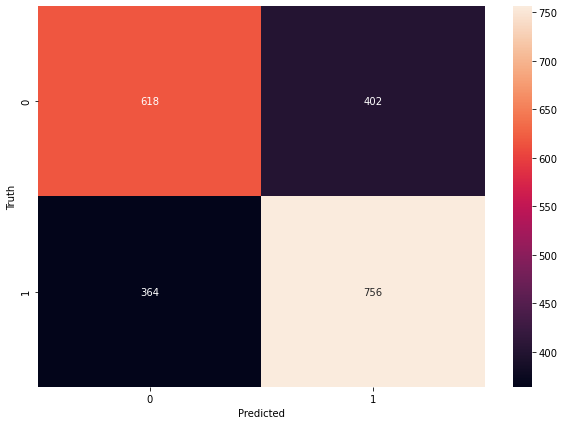

In [90]:
import seaborn as sn
import matplotlib.pyplot as plt
plt.figure(figsize = (10,7))
sn.heatmap(matrix, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Truth')